In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import split
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

## Расчёт доступности объектов здравоохранение

[Задача](https://github.com/NorthGateVologda/NorthGate/issues/20)

В рамках данной задачи, мы делим данный городской округ $G$ на заданные квадраты и
полигоны по краям границы используя сетку с заданным шагом.

$$
P = \{p |S(p) = const, p \in G\}
$$

Считаем количество населения $N$ для каждого квадрата $p$ по количеству домов $h$
используя функцию $H$ возвращающую среднее количество жителей по году постройки здания:

$$
N = \{ n | \sum_{i=1}^{k} H(h_i), h \in p \}
$$

где к вышеупомянутым $n$ это население в заданном квадрате, а $k$ это количество зданий в заданном квадрате.

Считаем потенциал оказания медицинских услуг $Q$ для каждого квадрата $p$ по количеству
медучреждений $m$ используя функцию $M$ возвращающую средний охват населения на учреждение:

$$
Q = \{ q | \sum_{i=1}^{l} M(h_i), m \in p \}
$$

где к вышеупомянутым $q$ это потенциальный охват учреждения, а $l$ это количество учреждений в заданном квадрате.

Считаем профицит доступности медицинских услуг:

$$
\frac{Q}{N}
$$



### Параметры алгоритма

In [2]:
# Имя городского округа
city = 'Архангельск'
# Шаг геодезической сети (наверное это как то по другому называется)
mesh_step = 1000
# Год постройки жилых зданий делящий набор на два подмножества
# Дом считается старым, если его год меньше или равен заданному
split_year = 1972
# Среднее количество в новых домах
upper_amount = 100
# Среднее количество в старых домах
lower_amount = 50
# Количество населения обслуживаемое медучреждением
med_amount = 500

### Загружаем данные

In [3]:
# Загружаем данные
buildings = gpd.read_file('GeoJSON/data/buildings.geojson')
zdrav = gpd.read_file('GeoJSON/data/objects_zdrav.geojson')
mun_obr = gpd.read_file('GeoJSON/data/mun_obr_all_bad.geojson')

In [4]:
buildings.head(3)

,id,city,year,geometry
0,3600851,г. Архангельск,1972,POINT (4500192.491 9488394.583)
1,3600852,г. Архангельск,1971,POINT (4500308.835 9488520.679)
2,3600853,г. Архангельск,1974,POINT (4500297.482 9488325.283)


In [5]:
zdrav.head(3)

,id,name,city,street,house,post,x,y,cpi_id,geometry
0,497,"Зубной лекарь, стоматологическая клиника, ООО ...",Архангельск,Троицкий проспект,12,,40.531366,64.532504,15347,POINT (4511931.077 9486294.630)
1,540,"Северодвинская городская больница №1, ГБУЗ",Северодвинск (Северодвинск городской округ),Серго Орджоникидзе,2а,164512,39.784852,64.561244,16904,POINT (4428829.428 9493738.840)
2,1196,"Стоматошка, ООО, центр семейной стоматологии",Северодвинск (Северодвинск городской округ),Ломоносова,97,164522,39.768076,64.547978,37139,POINT (4426962.001 9490301.724)


In [6]:
mun_obr.head(3)

,id,name,type,level,sub,region,people,sum_bad,percent,road_density,road_demand,id_full,count_bad,avg_free_speed_to_limit,sum_all,sum_all_signal,geometry
0,1,Приморский,Район,3,3,Архангельская область,25639,454.179,22.587524,0.039698,7817,191.0,1276,0.540127,4566.956058,2010.751573,"MULTIPOLYGON (((6752340.851 16757142.533, 6747..."
1,2,Онежский,Район,3,3,Архангельская область,30762,497.027,52.266499,0.199816,258,198.0,557,0.769203,5690.231916,950.947574,"MULTIPOLYGON (((4137834.751 9506878.049, 41661..."
2,3,Архангельск,Городской округ,3,3,Архангельская область,358594,22.830,1.136748,5.871852,6029,202.0,110,0.635683,2046.616862,2008.360347,"MULTIPOLYGON (((4508803.091 9540731.081, 45093..."


### Ограничиваем данные

In [7]:
area_type = 'Городской округ'
mun_obr = mun_obr[(mun_obr.name==city) & (mun_obr['type']==area_type)]
mun_obr.head(3)

,id,name,type,level,sub,region,people,sum_bad,percent,road_density,road_demand,id_full,count_bad,avg_free_speed_to_limit,sum_all,sum_all_signal,geometry
2,3,Архангельск,Городской округ,3,3,Архангельская область,358594,22.83,1.136748,5.871852,6029,202.0,110,0.635683,2046.616862,2008.360347,"MULTIPOLYGON (((4508803.091 9540731.081, 45093..."


In [8]:
zdrav = zdrav[zdrav.city==city]
zdrav.head(3)

,id,name,city,street,house,post,x,y,cpi_id,geometry
0,497,"Зубной лекарь, стоматологическая клиника, ООО ...",Архангельск,Троицкий проспект,12,,40.531366,64.532504,15347,POINT (4511931.077 9486294.630)
3,1449,"Arctic Smile, клиника эстетической стоматологии",Архангельск,Советских Космонавтов проспект,115,163000,40.532484,64.545325,44992,POINT (4512055.475 9489614.533)
5,1940,"Альтаир, ООО, стоматологическая клиника",Архангельск,Гагарина,45,163045,40.557178,64.556126,60521,POINT (4514804.394 9492412.583)


### Задаём функция разбиения мультиполигона

In [9]:
# Функция разбиения мультиполигона
def explodeMultiPolygon(indf):
    outarr = []
    for _, row in indf.iterrows():
        assert type(row.geometry) == MultiPolygon
        for geom in row.geometry.geoms:
            obj = {}
            obj['people'] = row.people
            obj['id_full'] = row.id_full
            obj['geometry'] = geom
            outarr.append(obj)
    return outarr

### Разбиваем мультиполигон

In [10]:
city_polys = explodeMultiPolygon(mun_obr)
arch = gpd.GeoDataFrame(city_polys, crs=mun_obr.crs.name)
arch.head()

,people,id_full,geometry
0,358594,202.0,"POLYGON ((4508803.091 9540731.081, 4509337.013..."


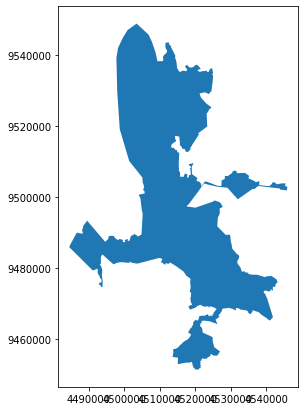

In [11]:
arch.plot(figsize=(7,7))

### Задаём функцию разбиения прямоугольника на квадраты с заданной стороной

In [12]:
def get_squares_from_rect(geom, mesh_step=2000):
    rect_coords = np.array(geom.boundary.coords.xy)
    y_list = rect_coords[1]
    x_list = rect_coords[0]
    y1 = min(y_list)
    y2 = max(y_list)
    x1 = min(x_list)
    x2 = max(x_list)
    width = x2 - x1
    height = y2 - y1

    xcells = int(np.round(width / mesh_step))
    ycells = int(np.round(height / mesh_step))

    yindices = np.linspace(y1, y2, ycells + 1)
    xindices = np.linspace(x1, x2, xcells + 1)
    horizontal_splitters = [
        LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
    ]
    vertical_splitters = [
        LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
    ]
    result = geom
    for splitter in vertical_splitters:
        result = MultiPolygon(split(result, splitter))
    for splitter in horizontal_splitters:
        result = MultiPolygon(split(result, splitter))

    return result

### Разбиваем прямоугольник замыкающий городской округ на полигоны

Проверяем функцию `get_squares_from_rect`. Важное замечание.
В первый раз сетка выходила за рамки родительского многоугольника, во втором нет.
Нужно будет исследовать этот момент.

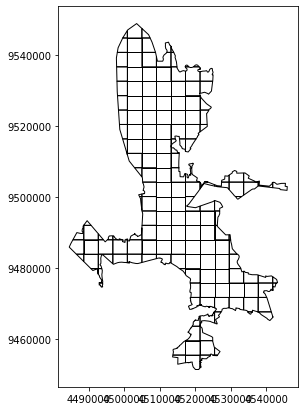

In [13]:
# Используем временное значение шага сетки
mesh_step_loc = 4000
city_geom = arch.iloc[0].geometry
squares = get_squares_from_rect(city_geom, mesh_step_loc)
city_mesh = gpd.GeoDataFrame(geometry=[squares], crs=arch.crs.name)
city_mesh.plot(figsize=(7,7), facecolor="none", edgecolor="black")

### Задаём функцию обёртку для разбиения

In [14]:
def split_geometry(geometry, crs, mesh_step, threashold=0.5):
    city_geom = arch.iloc[0].geometry
    squares = get_squares_from_rect(city_geom, mesh_step)
    city_squares = gpd.GeoDataFrame(geometry=[squares], crs=arch.crs.name)
    city_inter_geom = city_squares[city_squares.intersects(city_geom)]
    city_values = city_inter_geom.geometry.values
    polys = []
    for geom in city_values[0].geoms:
        if ((geom.intersection(city_geom)).area / geom.area) >= threashold:
            polys.append(geom)
    return gpd.GeoDataFrame(geometry=polys, crs=crs)

### Разбиваем сетку на полигоны

На всякий случай отсекаем лишние полигоны

In [15]:
city_geom = arch.iloc[0].geometry
city_mesh = split_geometry(city_geom, arch.crs.name, mesh_step)
city_mesh.head(3)

,geometry
0,"POLYGON ((4508803.091 9540731.081, 4509002.186..."
1,"POLYGON ((4508656.352 9539807.261, 4507649.788..."
2,"POLYGON ((4507649.788 9539807.261, 4506643.225..."


### Выводим все актуальные геоданные

Наблюдаем, что объекты здравоохранения сосредоточены в центре.
Необходимо уменьшить шаг сетки.
Используем параметр алгоритма.

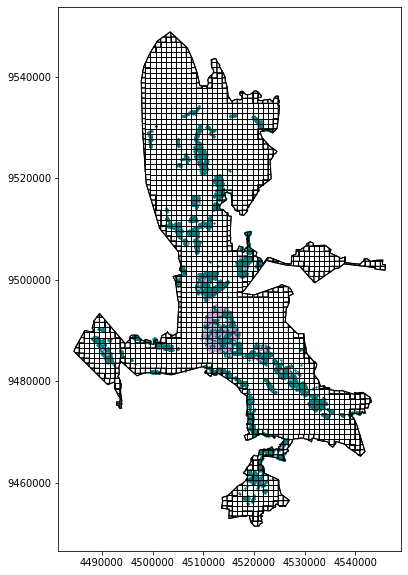

In [16]:
ax = arch.plot(figsize=(10,10), facecolor="none", edgecolor="black")
ax = buildings.plot(ax=ax, figsize=(10,10), facecolor="teal", markersize=2)
ax = zdrav.plot(ax=ax, figsize=(10,10), facecolor="plum", markersize=2)
city_mesh.plot(ax=ax, figsize=(10,10), facecolor="none", edgecolor="black")

### Считаем плонтость населения

Считаем основываясь на жилый постройках и годах строительства каждой постройки.
Для этого в параметрах выделено три переменных с экспертными значениями.

* `split_year`
* `upper_amount`
* `lower_amount`

In [17]:
# Добовляем колонку к основному набору
city_mesh['people'] = 0

### Создаём набор данных с аккумулированными значениями по геолокации

In [18]:
population = {}
cnt = 0
for idx, row in city_mesh.iterrows():
    square = row.geometry
    houses = buildings[buildings.intersects(square)]
    for _, house in houses.iterrows():
        residents = lower_amount if house.year <= split_year else upper_amount
        if idx in population:
            amount = population[idx]
            population[idx] = amount + residents
        else:
            population[idx] = residents

### Интегрируем данные в основной набор

In [19]:
city_mesh['people'] = city_mesh.index.map(population)
city_mesh['people'] = city_mesh['people'].fillna(0)
city_mesh['people'] = city_mesh['people'].astype(int)
# Убираем квадраты с нулевым населением
city_mesh = city_mesh[city_mesh.people != 0]
city_mesh.head(3)

,geometry,people
221,"POLYGON ((4509662.915 9533780.925, 4508656.352...",200
249,"POLYGON ((4509662.915 9532776.536, 4508656.352...",400
250,"POLYGON ((4508656.352 9532776.536, 4507649.788...",900


### Выводим граффик плотности населения

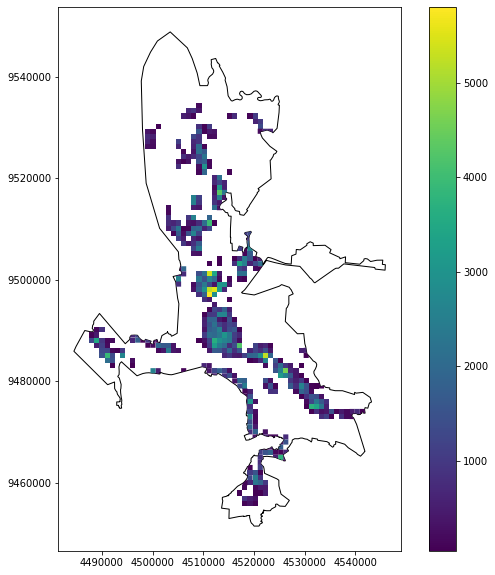

In [20]:
ax = arch.plot(figsize=(10,10), facecolor="none", edgecolor="black")
city_mesh.plot(ax=ax, figsize=(10,10), column='people', legend=True)

### Считаем плонтость оказывания медицинских услуг

Считаем основываясь на переменной `med_amount` с экспертным значением.

In [21]:
# Добовляем колонку к основному набору
city_mesh['medicine'] = 0

### Создаём набор данных с аккумулированными значениями по геолокации

In [22]:
medicine = {}
cnt = 0
for idx, row in city_mesh.iterrows():
    square = row.geometry
    hospitals = zdrav[zdrav.intersects(square)]
    for _, hospital in hospitals.iterrows():
        if idx in medicine:
            amount = medicine[idx]
            medicine[idx] = amount + med_amount
        else:
            medicine[idx] = med_amount

### Интегрируем данные в основной набор

In [23]:
city_mesh['medicine'] = city_mesh.index.map(medicine)
city_mesh['medicine'] = city_mesh['medicine'].fillna(0)
city_mesh['medicine'] = city_mesh['medicine'].astype(int)
city_mesh[city_mesh.medicine>0].head(3)

,geometry,people,medicine
266,"POLYGON ((4520735.113 9531772.146, 4519728.549...",1050,500
516,"POLYGON ((4509662.915 9522732.642, 4508656.352...",1450,500
710,"POLYGON ((4509662.915 9514697.527, 4508656.352...",950,500


### Выводим граффик потенциала оказания медицинских услуг

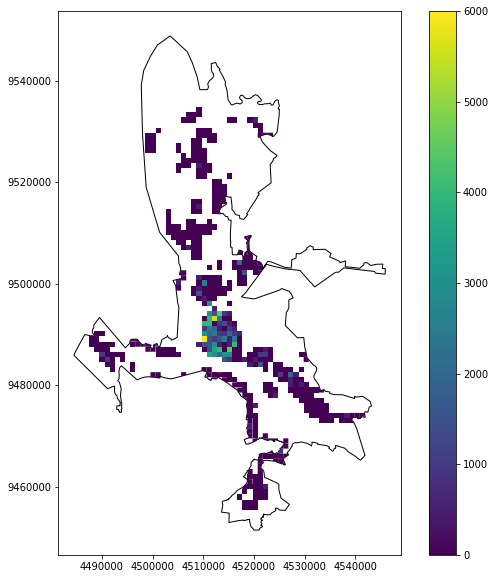

In [24]:
ax = arch.plot(figsize=(10,10), facecolor="none", edgecolor="black")
city_mesh.plot(ax=ax, figsize=(10,10), column='medicine', legend=True)

### Расчитываем отношение популяции к потенциалу оказания медицинских услуг

In [25]:
city_mesh['proficit'] = city_mesh['medicine'] / city_mesh['people']
city_mesh[city_mesh.medicine>0]

,geometry,people,medicine,proficit
266,"POLYGON ((4520735.113 9531772.146, 4519728.549...",1050,500,0.476190
516,"POLYGON ((4509662.915 9522732.642, 4508656.352...",1450,500,0.344828
710,"POLYGON ((4509662.915 9514697.527, 4508656.352...",950,500,0.526316
842,"POLYGON ((4507649.788 9506662.413, 4506643.225...",350,500,1.428571
894,"POLYGON ((4517715.422 9503649.245, 4516708.859...",800,2000,2.500000
...,...,...,...,...
1845,"POLYGON ((4520735.113 9475526.343, 4519728.549...",300,500,1.666667
1881,"POLYGON ((4538853.254 9473517.565, 4537846.691...",200,500,2.500000
1947,"POLYGON ((4519728.549 9471508.786, 4518721.986...",1500,500,0.333333
2048,"POLYGON ((4525767.930 9466486.839, 4524761.366...",1750,1000,0.571429


### Переводим в угловую систему координат

In [26]:
city_mesh_wgs84 = city_mesh.to_crs('WGS84')
arch_wgs84 = arch.to_crs('WGS84')

### Визуализируем профицит

Визуализируем профицит, как отношение потенциала оказания мед услуг к количество населения в заданном квадрате.

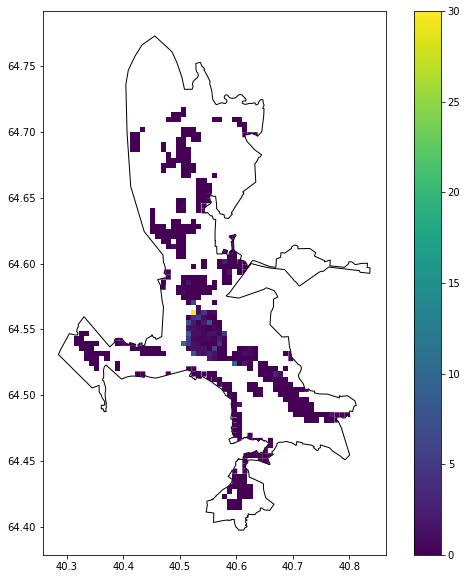

In [27]:
ax = arch_wgs84.plot(figsize=(10,10), facecolor="none", edgecolor="black")
city_mesh_wgs84.plot(ax=ax, figsize=(10,10), column='proficit', legend=True)

### Сохраняем Dataset для визуализации в Datalens

In [28]:
def convert(data):
    all_res = []
    for _, row in data.iterrows():
        x, y = row.geometry.exterior.xy
        pairs = zip(x, y)
        coords = []
        for pair in pairs:
            coords.append([pair[1], pair[0]])
        obj = {}
        obj['people'] = row.people
        obj['medicine'] = row.medicine
        obj['proficit'] = row.proficit
        obj['geometry'] = [coords]

        all_res.append(obj)
    return pd.DataFrame(all_res)

df = convert(city_mesh_wgs84)
df

,people,medicine,proficit,geometry
0,200,0,0.00000,"[[[64.71531613016083, 40.51099122768549], [64...."
1,400,0,0.00000,"[[[64.71146216469891, 40.51099122768549], [64...."
2,900,0,0.00000,"[[[64.71146216469891, 40.50194911456859], [64...."
3,700,0,0.00000,"[[[64.71146216469891, 40.492907001451684], [64..."
4,1050,500,0.47619,"[[[64.70760765045972, 40.610454471971416], [64..."
...,...,...,...,...
499,500,0,0.00000,"[[[64.41695062925233, 40.60141235885452], [64...."
500,900,0,0.00000,"[[[64.41695062925233, 40.592370245737605], [64..."
501,100,0,0.00000,"[[[64.41305423044668, 40.610454471971416], [64..."
502,300,0,0.00000,"[[[64.41305423044668, 40.60141235885452], [64...."


In [29]:
df.to_csv('GeoJSON/data/people_medicin_lense.csv', index=False)